<a href="https://colab.research.google.com/github/DanielhCarranza/Machine-Learning-in-Health/blob/master/Blood_Cells_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blood Cells Detection

This dataset contains 12,500 augmented images of blood cells (JPEG) with accompanying cell type labels (CSV). There are approximately 3,000 images for each of 4 different cell types grouped into 4 different folders (according to cell type). The cell types are Eosinophil, Lymphocyte, Monocyte, and Neutrophil. This dataset is accompanied by an additional dataset containing the original 410 images (pre-augmentation) as well as two additional subtype labels (WBC vs WBC) and also bounding boxes for each cell in each of these 410 images (JPEG + XML metadata). More specifically, the folder 'dataset-master' contains 410 images of blood cells with subtype labels and bounding boxes (JPEG + XML), while the folder 'dataset2-master' contains 2,500 augmented images as well as 4 additional subtype labels (JPEG + CSV). There are approximately 3,000 augmented images for each class of the 4 classes as compared to 88, 33, 21, and 207 images of each in folder 'dataset-master'.

* [FastRCNN](https://medium.com/analytics-vidhya/a-practical-implementation-of-the-faster-r-cnn-algorithm-for-object-detection-part-2-with-cac45dada619)

## Setup

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ingbiodanielh","key":"42c086b139c8c921f1285d422d295137"}'}

In [ ]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d paultimothymooney/blood-cells

! unzip blood-cells.zip
! unzip dataset2-master.zip

### GCP

In [ ]:
from google.colab import auth
auth.authenticate_user()

project_id = 'project'
bucket_name='project-datasets'


!gcloud config set project {project_idJL}

def ls_gcp(path):
  ! gsutil ls gs://{path}

def upload_files_to_gcp(local_path, bucket_path):
  ! gsutil -m cp -r {local_path} gs://{bucket_path}

def download_files_from_gcp(bucket_path, local_path):
#   if not os.path.isdir(local_path): os.mkdir(local_path)
  ! gsutil -m cp -r gs://{bucket_path} {local_path} 


## Modules

In [ ]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.callbacks.hooks import *
from fastai.vision.interpret import SegmentationInterpretation

import os
import cv2 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import auc, roc_curve, precision_recall_curve
from sklearn.metrics import classification_report

In [ ]:
ls

blood-cells.zip   dataset2-master.zip  kaggle.json  sample_data/
dataset2-master/  dataset-master.zip   __MACOSX/


In [ ]:
path=Path('dataset2-master')
path.ls()

[PosixPath('dataset2-master/labels.csv'),
 PosixPath('dataset2-master/images'),
 PosixPath('dataset2-master/.DS_Store')]

In [ ]:
img=open_image((path/'images/TRAIN/EOSINOPHIL').ls()[0])
img.shape

torch.Size([3, 240, 320])

In [ ]:
tfms= get_transforms(flip_vert=True, max_warp=0.)

In [ ]:
data= ImageDataBunch.from_folder((path/'images'), train='TRAIN',valid='TEST',test='TEST_SIMPLE', 
                                 num_workers=4,
                                 bs=64,
                                 size=224,
                                ds_tfms=tfms).normalize()

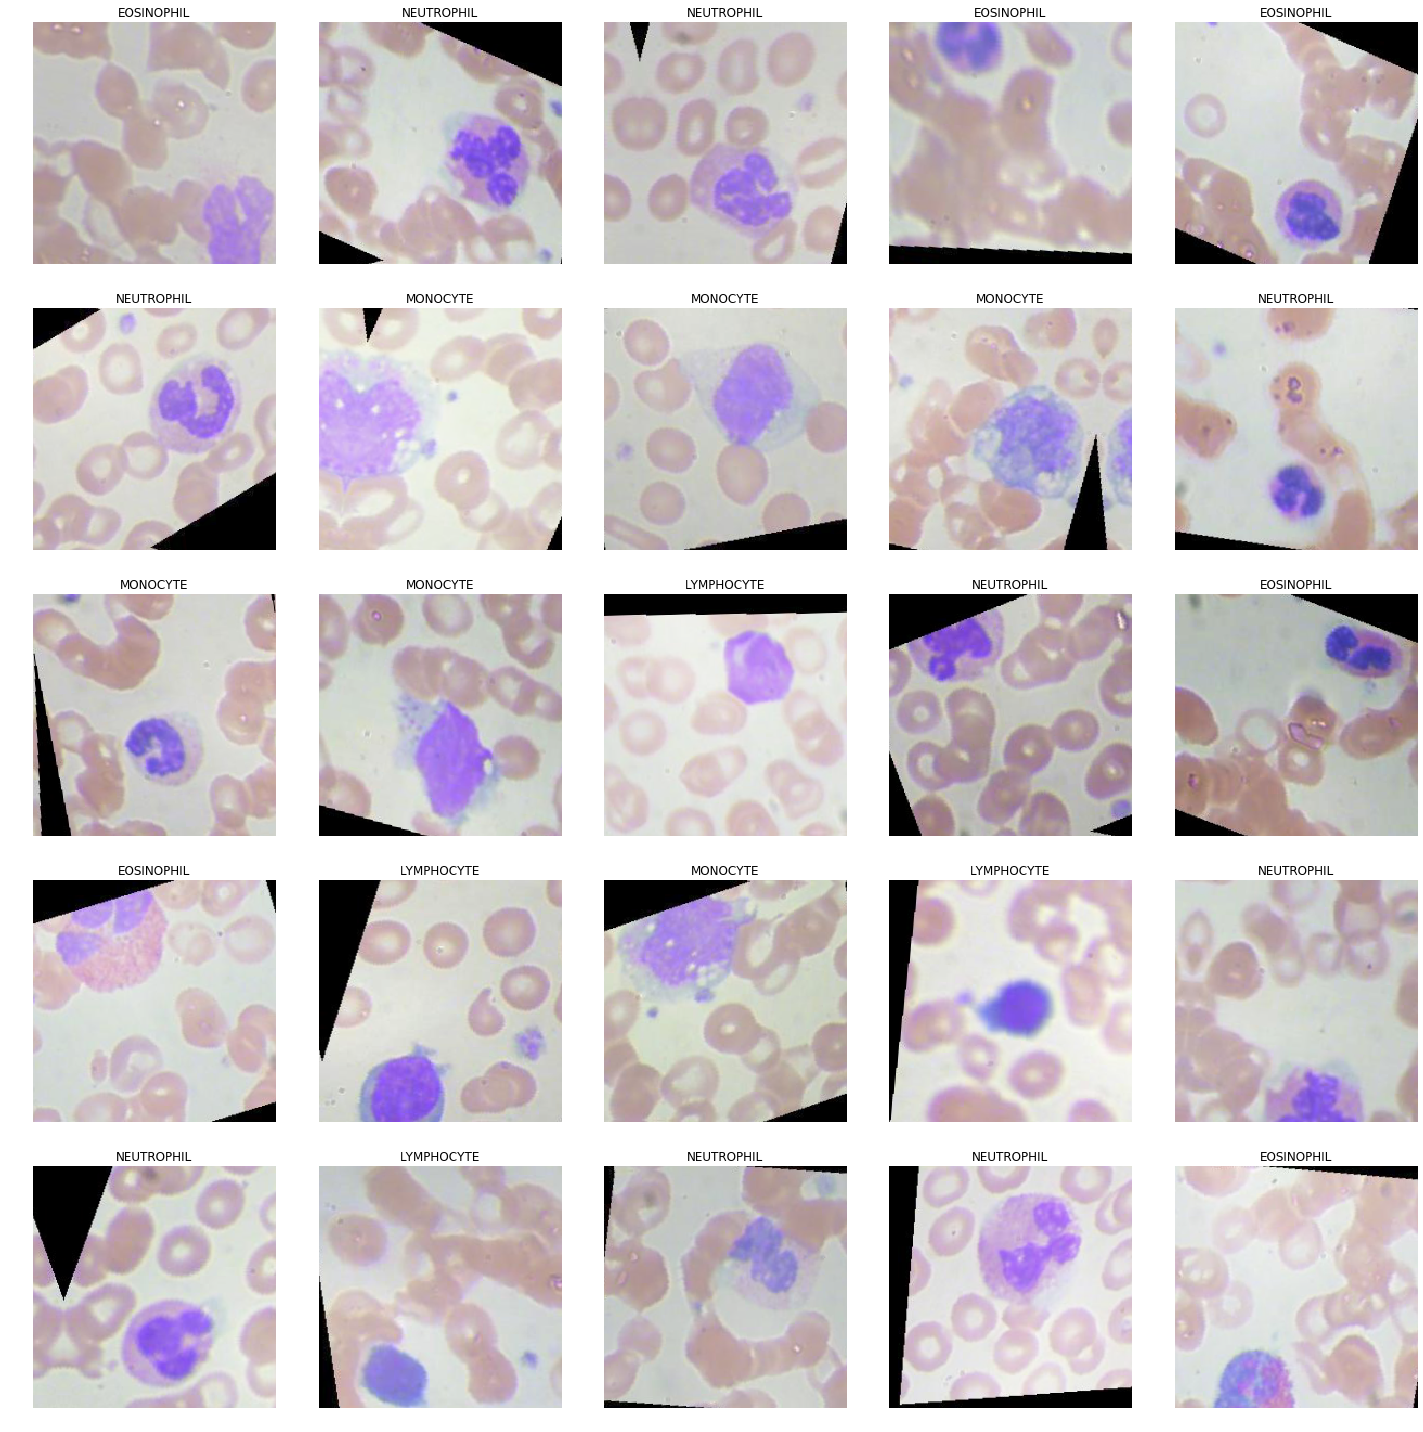

In [ ]:
data.show_batch()

## Training

### ResNet50

In [ ]:
cbfs = [ReduceLROnPlateauCallback,
        partial(SaveModelCallback,every='epoch',name='res50_224'),
        ShowGraph]

In [ ]:
learner= cnn_learner(data, models.resnet50, metrics= [accuracy], callback_fns=cbfs)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 100125976.91it/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.562927,0.566152,0.802975,01:30
1,0.221195,0.583579,0.850422,01:28
2,0.123176,0.964933,0.797346,01:28
3,0.100242,1.073596,0.780860,01:28
4,0.095841,1.061464,0.833534,01:28
5,0.081855,1.430808,0.794532,01:28
6,0.062412,1.378664,0.851628,01:27
7,0.061076,1.174668,0.855649,01:28
8,0.036663,1.313202,0.850422,01:28
9,0.033145,1.065097,0.833936,01:27


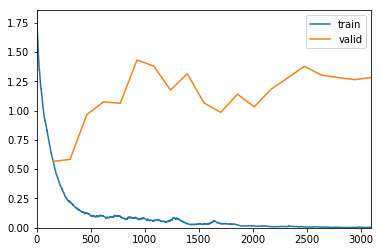

Epoch 1: reducing lr to 0.0005600000000000001
Epoch 2: reducing lr to 0.0010400000000000001
Epoch 3: reducing lr to 0.0015200000000000003
Epoch 4: reducing lr to 0.0018713843876330617
Epoch 5: reducing lr to 0.0020000000000000005
Epoch 6: reducing lr to 0.001974928012470175
Epoch 7: reducing lr to 0.0019009692640269478
Epoch 8: reducing lr to 0.0017818323551421003
Epoch 9: reducing lr to 0.0016234913078995265
Epoch 10: reducing lr to 0.001433886003582602
Epoch 11: reducing lr to 0.0012225240438725788
Epoch 12: reducing lr to 0.0010000040000000003
Epoch 13: reducing lr to 0.0007774839561274217
Epoch 14: reducing lr to 0.0005661219964173986
Epoch 15: reducing lr to 0.00037651669210047407
Epoch 16: reducing lr to 0.00021817564485790013
Epoch 17: reducing lr to 9.90387359730526e-05
Epoch 18: reducing lr to 2.5079987529825117e-05
Epoch 19: reducing lr to 8.000000000000002e-09


In [ ]:
lr= 1e-1
learner.fit_one_cycle(20, slice(1e-3,1e-2, lr))

In [ ]:
learner.save('res50_224_classification-88acc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


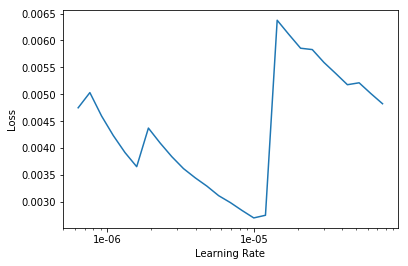

In [ ]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.009358,1.195114,0.873341,01:56
1,0.004280,1.264700,0.882589,01:57
2,0.002256,1.105458,0.887415,01:56
3,0.003355,1.175334,0.878166,01:57
4,0.004577,1.192418,0.867712,02:09
5,0.007443,1.071851,0.881785,07:29
6,0.007929,1.092738,0.874146,03:28
7,0.010486,1.235718,0.880981,03:26
8,0.005484,1.324757,0.880981,03:24
9,0.005055,1.233292,0.885404,02:30


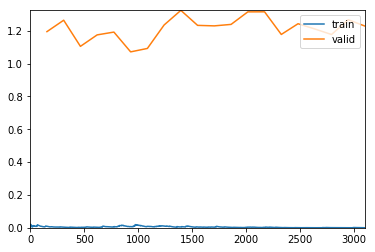

Epoch 1: reducing lr to 5.600000000000004e-06
Epoch 3: reducing lr to 1.5200000000000004e-05
Epoch 4: reducing lr to 1.871384387633062e-05
Epoch 6: reducing lr to 1.9749280124701755e-05
Epoch 7: reducing lr to 1.900969264026948e-05
Epoch 8: reducing lr to 1.7818323551421008e-05
Epoch 9: reducing lr to 1.623491307899527e-05
Epoch 10: reducing lr to 1.433886003582602e-05
Epoch 11: reducing lr to 1.222524043872579e-05
Epoch 12: reducing lr to 1.0000040000000004e-05
Epoch 13: reducing lr to 7.774839561274218e-06
Epoch 14: reducing lr to 5.661219964173987e-06
Epoch 15: reducing lr to 3.7651669210047406e-06
Epoch 16: reducing lr to 2.1817564485790012e-06
Epoch 17: reducing lr to 9.903873597305262e-07
Epoch 18: reducing lr to 2.5079987529825117e-07
Epoch 19: reducing lr to 8.000000000000003e-11


In [ ]:
lr= 1e-4
learner.fit_one_cycle(20, slice(1e-5, lr), wd=1e-2)

In [ ]:
learner.save('res50_224_classification-88acc')

### Resnet34 

In [ ]:
cbfs = [ReduceLROnPlateauCallback,
        partial(SaveModelCallback,every='epoch',name='res34_224'),
        ShowGraph]

In [ ]:
learner= cnn_learner(data, models.resnet34, metrics=[accuracy], callback_fns=cbfs).to_fp16()

epoch,train_loss,valid_loss,accuracy,time
0,0.695400,0.642833,0.761560,01:14
1,0.263272,0.674767,0.793325,01:14
2,0.178694,0.593585,0.860877,01:14
3,0.111892,0.667655,0.855247,01:13
4,0.090962,0.846676,0.852031,01:13
5,0.062418,0.789692,0.846803,01:13
6,0.047363,0.934421,0.859670,01:13
7,0.034923,0.753477,0.871733,01:13
8,0.016825,0.749594,0.869723,01:13
9,0.021955,0.821829,0.865702,01:13


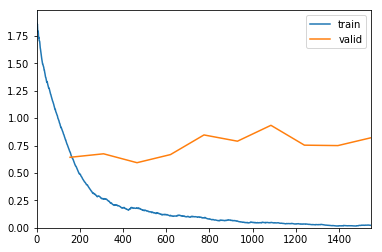

Epoch 1: reducing lr to 0.0015200000000000003
Epoch 3: reducing lr to 0.0019009692640269478
Epoch 4: reducing lr to 0.0016234913078995265
Epoch 5: reducing lr to 0.0012225240438725788
Epoch 6: reducing lr to 0.0007774839561274217
Epoch 7: reducing lr to 0.00037651669210047407
Epoch 8: reducing lr to 9.90387359730526e-05
Epoch 9: reducing lr to 8.000000000000002e-09


In [ ]:
lr=1e-1
learner.fit_one_cycle(10, slice(1e-3,1e-2, lr))

In [ ]:
learner.save('res34_classification-87acc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


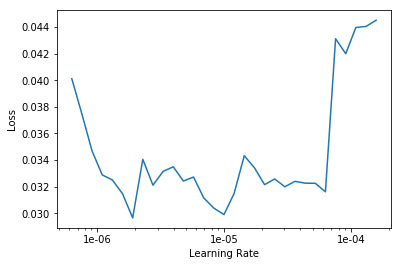

In [ ]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.009866,0.896622,0.874548,01:19
1,0.008047,0.898406,0.876156,01:18
2,0.006419,0.893488,0.874548,01:18
3,0.007804,0.797068,0.873341,01:17
4,0.006994,0.908983,0.866908,01:18
5,0.004168,0.906882,0.870929,01:17
6,0.005075,0.910724,0.862485,01:17
7,0.005461,0.898853,0.870527,01:18
8,0.002487,0.906730,0.876156,01:18
9,0.003614,0.895823,0.879373,01:18


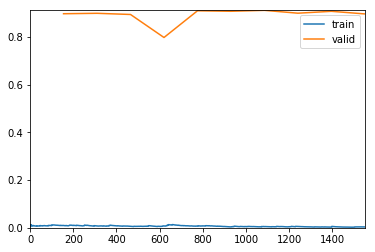

Epoch 1: reducing lr to 7.600000000000002e-06
Epoch 4: reducing lr to 8.117456539497635e-06
Epoch 5: reducing lr to 6.112620219362895e-06
Epoch 6: reducing lr to 3.887419780637109e-06
Epoch 7: reducing lr to 1.8825834605023703e-06
Epoch 8: reducing lr to 4.951936798652631e-07
Epoch 9: reducing lr to 4.000000000000002e-11


In [ ]:
lr= 1e-5
learner.fit_one_cycle(10, slice(lr, 5e-5), wd=1e-3)

## Evaluation

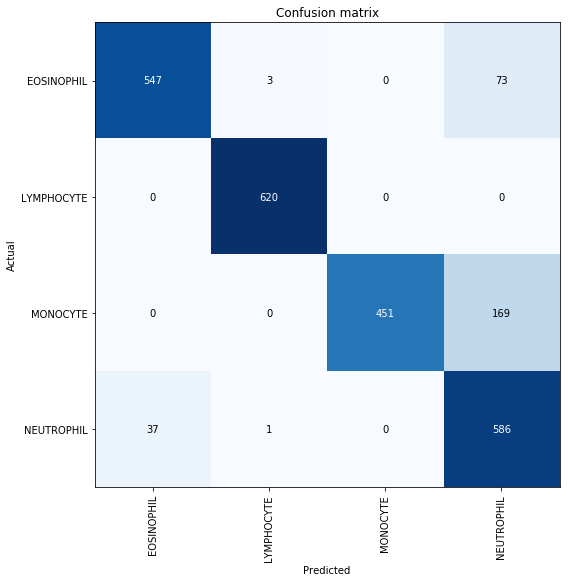

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(10,8))

In [ ]:
# Predictions of the validation data
preds, y_true=learner.get_preds()
y_true.shape, preds.shape

(torch.Size([2487]), torch.Size([2487, 4]))

In [ ]:
y_true=y_true.numpy() 
preds=np.argmax(preds.numpy(), axis=-1)
y_true.shape, preds.shape

((2487,), (2487,))

In [ ]:
classes=data.single_ds.y.classes

In [ ]:
# Generate a classification report
report = classification_report(y_true, preds, target_names=classes)
print(report)

              precision    recall  f1-score   support

  EOSINOPHIL       0.94      0.88      0.91       623
  LYMPHOCYTE       0.99      1.00      1.00       620
    MONOCYTE       1.00      0.73      0.84       620
  NEUTROPHIL       0.71      0.94      0.81       624

    accuracy                           0.89      2487
   macro avg       0.91      0.89      0.89      2487
weighted avg       0.91      0.89      0.89      2487



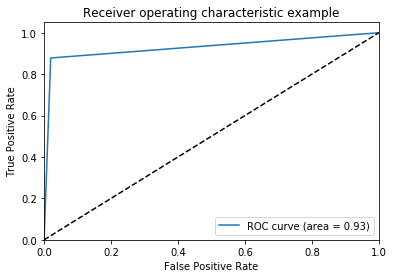

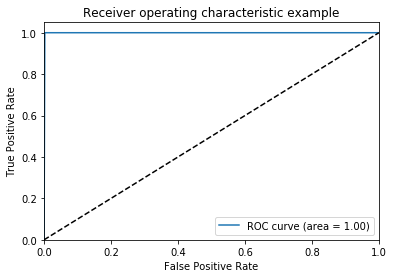

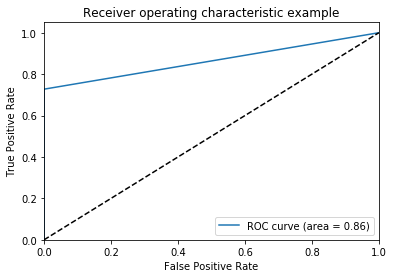

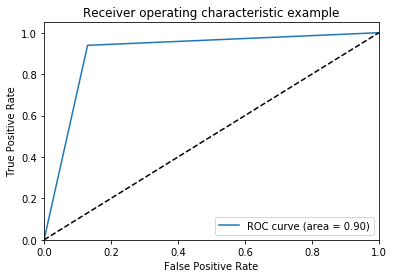

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=len(classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_true))[:, i], np.array(pd.get_dummies(preds))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
learner.show_results()

### Save Model

In [ ]:
learner.export(file='models/res50_512_classification-985acc.pkl')

In [ ]:
stage_model= 'res50_512_classification-985acc.pth'
model_file = 'res50_512_classification-985acc.pkl'
path_local_models = (train_path/'models')
model_local_path = str(path_local_models/stage_model)
# upload_files_to_gcp(model_local_path, path_ophthalmology_models)
ls_gcp(path_ophthalmology_models)

### HeatMap

In [ ]:
def heatMap(x, data, learner, size=(0,224,224,0)):
    """HeatMap"""
    
    # Evaluation mode
    m=learner.model.eval()
    
    # Denormalize the image
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    # hook the activations
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, 1].backward()

    # Activations    
    acts=hook_a.stored[0].cpu()
    
    # Avg of the activations
    avg_acts=acts.mean(0)
    
    # Show HeatMap
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(avg_acts, alpha=0.6, extent=size,
              interpolation='bilinear', cmap='magma')
    

Category EOSINOPHIL

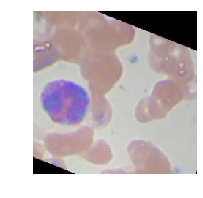

In [ ]:
x,y = data.valid_ds[2]
x.show()
data.valid_ds.y[2]

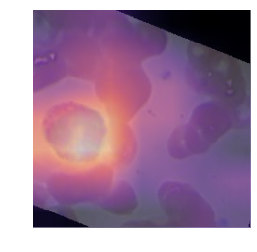

In [ ]:
heatMap(x,data,learner, size=(0,224,224,0))

## Inference

In [ ]:
class Inference():

    def __init__(self, path, file_name):
        """ Inference 
        :path = path to the .pkl file
        :file_name
        return: class prediction
        """
        self.learner = load_learner(path, file_name)
        self.learner.to_fp32()
        self.classes= self.learner.data.single_ds.y.classes

    def __call__(self, img, print_probs=True, heatmap=False):
        img = open_image(img) if not isinstance(
            img, fastai.vision.image.Image) else img
        pred_class, idx, probs = self.learner.predict(img)
        
        if print_probs:
          for i,p in enumerate(probs): print(f"{self.classes[i]} {(p*100):.3f}")
        if heatmap: self.show_heatmap(img)
        return pred_class, idx, probs
      
    def show_heatmap(self, img):
        heatMap(img, self.learner.data, self.learner, size=(0,512,512,0))
        plt.show()
    

In [ ]:
predict_blood_cells=Inference(path_local_models, model_file)